In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path
from tqdm.auto import tqdm
from torchinfo import summary
import PIL
from PIL import Image

e:\Anaconda\envs\pytorch39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# DEVICE AGNOSTIC CODE.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download the data.
import requests
import zipfile
from pathlib import Path
import os

# 1. Setup the path.
data_path = Path("images_try")

# 2. Setup image path
image_path = data_path / "pizza_steak_sushi"

# 3. Check if the directory exists or not.
if image_path.is_dir():
    print(f"[INFO] : Directory Already Exists")
else:
    print(f"[INFO] : Making the Directory")
    image_path.mkdir(parents=True , exist_ok=True)
# 4. Download the data.
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("DOWNLOADING THE DATA!!!")
    f.write(request.content)

# Unzip the file.
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("UNZIPPING THE DATA...")
    zip_ref.extractall(image_path)
os.remove(data_path / "pizza_steak_sushi.zip")

[INFO] : Directory Already Exists
DOWNLOADING THE DATA!!!
UNZIPPING THE DATA...


In [4]:
# Setup Train and Test Dir.
train_dir = image_path/"train"
test_dir =  image_path/"test"
print(train_dir,test_dir)

images_try\pizza_steak_sushi\train images_try\pizza_steak_sushi\test


In [6]:
def create_effnetb2_mode(num_classes:int):
    
    ## Intitiate model and transforms
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights = weights)
    transforms = weights.transforms()
    
    ## Freeze the layers
    for param in model.features.parameters():
        param.requires_grad = False
        
    ## Change the classifier
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3 , inplace=True),
        nn.Linear(in_features=1408 , out_features=num_classes)
    )
    return model , transforms

In [7]:
effnetb2 , effnetb2_transforms = create_effnetb2_mode(num_classes=3)
summary(model = effnetb2,
       input_size = (32,3,224,224),
       col_names = ["input_size" , "output_size", "num_params" , "trainable"],
       col_width=20,
       row_settings=['var_names'])

e:\Anaconda\envs\pytorch39\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
e:\Anaconda\envs\pytorch39\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [8]:
train_data = ImageFolder(root = train_dir,transform=effnetb2_transforms)
test_data = ImageFolder(root = test_dir , transform=effnetb2_transforms)
print(train_data , test_data)
class_names = train_data.classes
print(class_names)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: images_try\pizza_steak_sushi\train
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: images_try\pizza_steak_sushi\test
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
['pizza', 'steak', 'sushi']


In [9]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x199d83079d0>,
 <torch.utils.data.dataloader.DataLoader at 0x199d8307070>)

In [13]:
def train_step(model : torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn : torch.nn.Module,
              optimizer : torch.optim.Optimizer,
              device = device):
    
    # Training mode.
    model.train()
    
    # initializing train_loss and train_acc values.
    train_loss ,train_acc = 0,0
    
    # loop through the dataloader and calculate the loss and accuracy.
    for batch,(x,y) in enumerate(dataloader):
        # putting x and y to target device.
        x,y = x.to(device), y.to(device)
        
        # y_logits
        y_pred = model(x)
        
        # loss
        loss = loss_fn(y_pred,y)
        train_loss += loss.item()
        
        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate the accuracy.
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
    
    ## Average Loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss , train_acc


def test_step(model : torch.nn.Module,
             dataloader : torch.utils.data.DataLoader,
             loss_fn = torch.nn.Module,
             device = device):
    
    # Evaluation mode.
    model.eval()
    
    test_loss , test_acc = 0,0
    
    # Inference_mode()
    with torch.inference_mode():
        # Looping through dataloader.
        for batch,(x,y) in enumerate(dataloader):
            # putting x,y to target device
            x,y = x.to(device), y.to(device)
            
            # forward pass
            y_pred = model(x)
            # loss
            loss = loss_fn(y_pred,y)
            # test_loss
            test_loss += loss.item()
            
            # Calculate the accuracy.
            test_pred_labels = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
            test_acc += (test_pred_labels==y).sum().item() / len(y_pred)
    # Average loss and accuracy.
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)    
    return test_loss, test_acc


def train(model:torch.nn.Module,
         train_dataloader : torch.utils.data.DataLoader,
         test_dataloader : torch.utils.data.DataLoader,
         optimizer : torch.optim.Optimizer,
         loss_fn : torch.nn.Module,
         epochs : int,
         device = device):
    
    # Create a empty dictionary
    results = {
        "train_loss" : [],
        "train_acc" : [],
        "test_loss" : [],
        "test_acc" : []
    }
    
    # Loop through training and testing step for a number of epochs.
    for epoch in tqdm(range(epochs)):
        train_loss , train_acc = train_step(model = model,
                                            dataloader = train_dataloader,
                                            optimizer=optimizer,
                                            loss_fn=loss_fn,
                                            device = device)
        
        test_loss , test_acc = test_step(model = model,
                                        dataloader=test_dataloader,
                                        loss_fn = loss_fn,
                                        device = device)
        print(f"EPOCH : {epoch} | Train Loss : {train_loss:.4f} | Train Acc : {train_acc:.4f} | Test Loss : {test_loss:.4f} | Test Acc : {test_acc:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

In [14]:
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                            lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

effnetb2_results = train(model = effnetb2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        epochs = 5,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        device = device)

 20%|██        | 1/5 [00:08<00:34,  8.57s/it]

EPOCH : 0 | Train Loss : 1.0687 | Train Acc : 0.4805 | Test Loss : 0.9087 | Test Acc : 0.7443


 40%|████      | 2/5 [00:13<00:18,  6.32s/it]

EPOCH : 1 | Train Loss : 0.8628 | Train Acc : 0.6914 | Test Loss : 0.8232 | Test Acc : 0.8163


 60%|██████    | 3/5 [00:17<00:11,  5.54s/it]

EPOCH : 2 | Train Loss : 0.7323 | Train Acc : 0.8750 | Test Loss : 0.7583 | Test Acc : 0.8163


 80%|████████  | 4/5 [00:22<00:05,  5.12s/it]

EPOCH : 3 | Train Loss : 0.7308 | Train Acc : 0.7109 | Test Loss : 0.6973 | Test Acc : 0.8153


100%|██████████| 5/5 [00:26<00:00,  5.38s/it]

EPOCH : 4 | Train Loss : 0.5672 | Train Acc : 0.9102 | Test Loss : 0.5733 | Test Acc : 0.8769


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


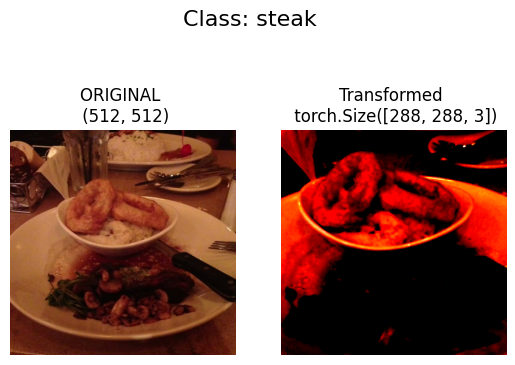

In [87]:
random_image_path = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.sample(random_image_path,k=1)
for images in random_image_path:
    with Image.open(images) as f:
        fig,ax = plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f"ORIGINAL \n {f.size}")
        ax[0].axis('off')

        transformed_image  = data_transform(f).permute(1,2,0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \n {transformed_image.shape}")
        ax[1].axis('off')

        fig.suptitle(f"Class: {images.parent.stem}", fontsize=16)

In [84]:
from torchvision import transforms
data_transform = transforms.Compose([
    # effenet transforms
    effnetb2_transforms,
    transforms.CenterCrop((200, 200)),
    transforms.Resize((288, 288)),
])

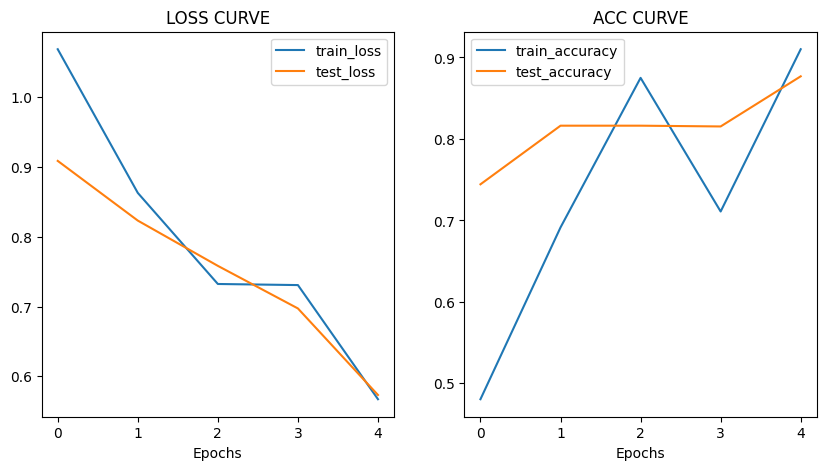

In [94]:
# Curves
train_loss = effnetb2_results['train_loss']
train_acc = effnetb2_results['train_acc']
test_loss = effnetb2_results['test_loss']
test_acc = effnetb2_results['test_acc']
EPOCHS = range(len(effnetb2_results['train_loss']))
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(EPOCHS,train_loss,label='train_loss')
plt.plot(EPOCHS,test_loss,label='test_loss')
plt.title("LOSS CURVE")
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(EPOCHS,train_acc, label='train_accuracy')
plt.plot(EPOCHS,test_acc, label='test_accuracy')
plt.title("ACC CURVE")
plt.xlabel('Epochs')
plt.legend()

In [97]:
model_path = Path("models")
model_path.mkdir(parents=True,exist_ok=True)

modelname = "effnetb2_TransferLearning01.pth"
model_save_path = model_path / modelname

torch.save(obj = effnetb2.state_dict(),
          f = model_save_path)

In [98]:
# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_mode(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="models/effnetb2_TransferLearning01.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

<All keys matched successfully>

In [100]:
from timeit import default_timer as timer
def predict(img):
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [101]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created By Sarthak Samantaray"
# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://06f0aac4fe20841b41.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
